<a href="https://colab.research.google.com/github/MariaJoseAlmeyda/Airbnb-Analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from sklearn.preprocessing import LabelEncoder
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# URL del archivo en GitHub
url = "https://raw.githubusercontent.com/MariaJoseAlmeyda/Airbnb-Analysis/refs/heads/main/listings%20(3).csv"
df = pd.read_csv(url)

# Resumen general
def resumen_dataframe(df):
    resumen = pd.DataFrame({
        'Tipo de Dato': df.dtypes,
        'Valores Únicos': df.nunique(),
        'Valores NA': df.isna().sum(),
        'Porcentaje NA (%)': (df.isna().sum() / len(df)) * 100,
        'Primeros 5 Valores': df.apply(lambda x: list(x.unique()[:5]))
    })
    return resumen

resumen = resumen_dataframe(df)
print(resumen)

                               Tipo de Dato  Valores Únicos  Valores NA  \
id                                    int64           26281           0   
name                                 object           24918           0   
host_id                               int64           11954           0   
host_name                            object            4107           3   
neighbourhood_group                 float64               0       26281   
neighbourhood                        object              16           0   
latitude                            float64           17285           0   
longitude                           float64           16114           0   
room_type                            object               4           0   
price                               float64            4118        3815   
minimum_nights                        int64              71           0   
number_of_reviews                     int64             552           0   
last_review              

**Limpieza y Manejo de datos**

In [6]:
# Eliminar columnas que no tienen ningun dato
df = df.drop(['neighbourhood_group', 'license'], axis=1)
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,499553,"Deluxe 4-BR penthouse, views, historic center",1297488,Petra,Cuauhtémoc,19.436210,-99.138740,Entire home/apt,4985.0,3,26,2024-10-28,0.17,2,117,1
1,501037,The best cheap flat in La Condesa!!,1364145,Humberto,Cuauhtémoc,19.415780,-99.174250,Entire home/apt,1150.0,5,134,2024-12-03,0.89,2,232,23
2,517503,Nice big room near airport,2547499,Irma Adriana,Venustiano Carranza,19.437840,-99.079030,Private room,550.0,1,281,2024-12-11,3.43,1,339,52
3,527473,"Nuestro bello departamento, un paraíso en la C...",158585,Fernando,Cuauhtémoc,19.418870,-99.173330,Entire home/apt,3654.0,1,354,2024-12-02,2.35,1,216,32
4,544105,Polanco great location! Priv Room in Shared Apart,2674950,Elizabeth,Miguel Hidalgo,19.442892,-99.201385,Private room,1007.0,2,67,2024-11-26,0.74,1,173,9


In [7]:
# Iterar sobre las columnas con NA, tomando en cuenta el barrio y el tipo de habitacion
for column in ['price', 'reviews_per_month']:
    df[column] = df.groupby(['neighbourhood', 'room_type'])[column].transform(lambda x: x.fillna(x.median()))

In [8]:
# Convertir 'last_review' a datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
print(df.dtypes)

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
number_of_reviews_ltm                      int64
dtype: object


In [30]:
# Reemplazar NA en la columna last_review con "unknown"
df['last_review'] = df['last_review'].fillna('unknown')

# Eliminar cualquier fila que aún tenga NA
df = df.dropna()

# Verificar
df.isna().sum()

,0
id,0
name,0
host_id,0
host_name,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0


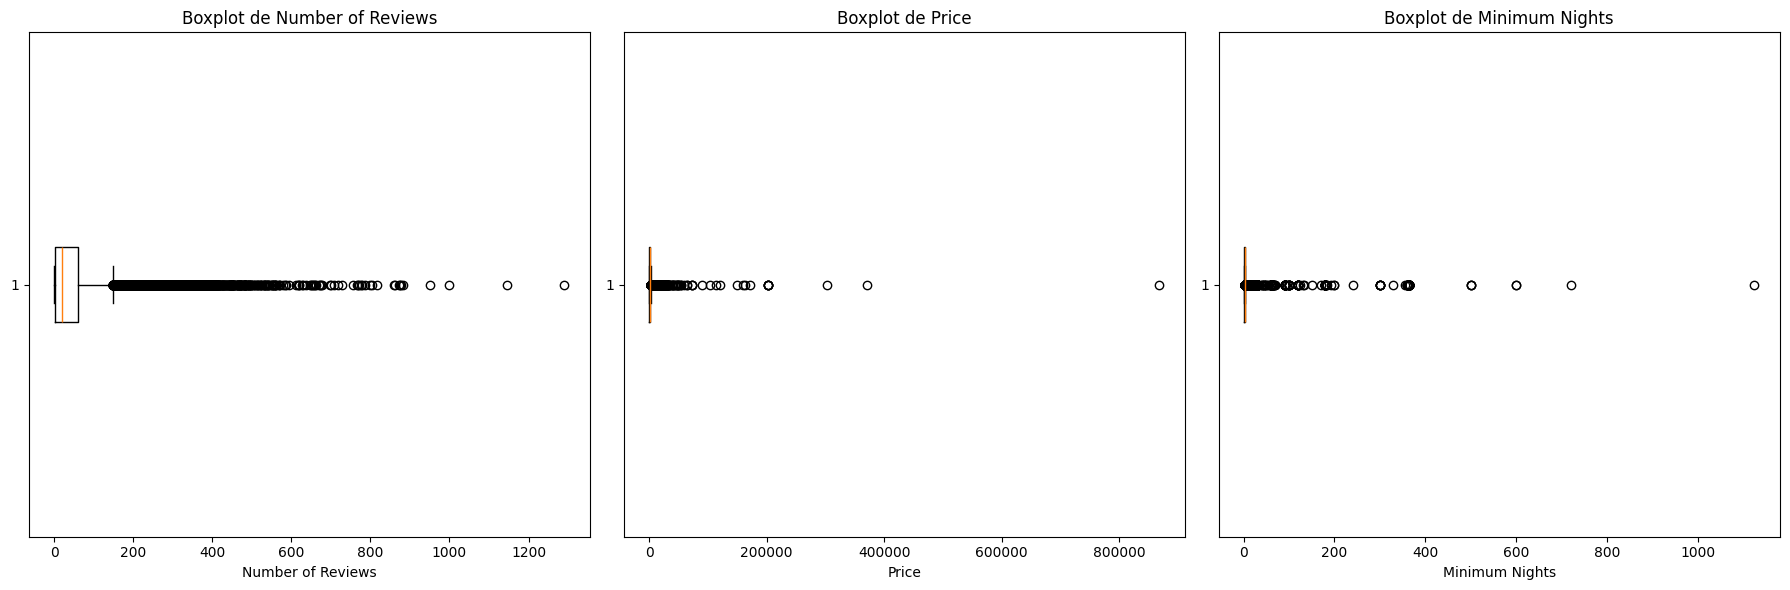

In [31]:
# Crear un boxplot para 'number_of_reviews', 'price' y 'minimum_nights'
plt.figure(figsize=(18, 6))

# 'number_of_reviews'
plt.subplot(1, 3, 1)
plt.boxplot(df['number_of_reviews'], vert=False)
plt.title('Boxplot de Number of Reviews')
plt.xlabel('Number of Reviews')

# 'price'
plt.subplot(1, 3, 2)
plt.boxplot(df['price'], vert=False)
plt.title('Boxplot de Price')
plt.xlabel('Price')

# 'minimum_nights'
plt.subplot(1, 3, 3)
plt.boxplot(df['minimum_nights'], vert=False)
plt.title('Boxplot de Minimum Nights')
plt.xlabel('Minimum Nights')

plt.tight_layout()
plt.show()


Los boxplots muestran una alta presencia de valores atípicos tanto en el número de reseñas como en los precios de los listados. Observamos que, aunque existen muchos outliers, especialmente en los precios (con un caso extremo superior a los 800,000), no todos ellos deben ser eliminados, ya que algunos podrían representar propiedades únicas o muy exclusivas. Sin embargo, eliminaremos aquellos valores que se encuentren significativamente alejados de la mayoría, ya que podrían distorsionar el análisis. Por ejemplo, aquellos con precios muy superiores al percentil 99 o con un número de reseñas inusualmente alto que no refleje el comportamiento típico de la mayoría de los listados.

In [32]:
# Calcular el rango intercuartílico para 'number_of_reviews'
Q1_reviews = df['number_of_reviews'].quantile(0.25)
Q3_reviews = df['number_of_reviews'].quantile(0.75)
IQR_reviews = Q3_reviews - Q1_reviews

# Definir límites
upper_limit_reviews = Q3_reviews + 2.5 * IQR_reviews

# Calcular el rango intercuartílico para 'price'
Q1_price = df['price'].quantile(0.25)
Q3_price = df['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Definir límites
upper_limit_price = Q3_price + 3 * IQR_price

# Calcular el rango intercuartílico para 'minimum_nights'
Q1_nights = df['minimum_nights'].quantile(0.25)
Q3_nights = df['minimum_nights'].quantile(0.75)
IQR_nights = Q3_nights - Q1_nights

# Definir límite
upper_limit_nights = 400

# Filtrar el DataFrame para eliminar esos outliers
df_cleaned = df[
    (df['number_of_reviews'] <= upper_limit_reviews) &
    (df['price'] <= upper_limit_price) &
    (df['minimum_nights'] <= upper_limit_nights)
]

# Verificar
print("Tamaño original:", df.shape)
print("Tamaño después de eliminar outliers:", df_cleaned.shape)


Tamaño original: (26275, 16)
Tamaño después de eliminar outliers: (23940, 16)


**Analisis Descriptivo General**



In [12]:
df_cleaned.describe()


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.394000e+04,2.394000e+04,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000,23940.000000
mean,5.887500e+17,2.281638e+08,19.404199,-99.166302,1280.280368,4.580827,36.281245,1.567081,16.056683,219.727444,13.071387
std,5.060552e+17,1.908465e+08,0.043348,0.033550,887.542502,21.490740,45.340429,1.675070,39.577884,132.764056,17.544916
min,3.579700e+04,7.365000e+03,19.177848,-99.334590,116.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,4.264220e+07,5.385925e+07,19.388411,-99.179022,627.000000,1.000000,3.000000,0.470000,1.000000,88.000000,0.000000
50%,7.349151e+17,1.702664e+08,19.414470,-99.167370,1050.000000,2.000000,17.000000,1.080000,3.000000,263.000000,6.000000
75%,1.055295e+18,3.983036e+08,19.431860,-99.154233,1603.000000,3.000000,53.000000,2.110000,10.000000,350.000000,20.000000
max,1.319510e+18,6.685337e+08,19.561010,-98.963360,4954.000000,365.000000,206.000000,63.930000,238.000000,365.000000,192.000000


En la columna **price**, el precio promedio de los listados es de 1,280.37 pesos mexicanos, con un precio mínimo de 116 pesos y un máximo de 4,954 pesos. El 50% de los precios están por debajo de 1,050 pesos, lo que indica que la mayoría de los listados son accesibles, pero también existen algunas propiedades significativamente más caras.

En la columna **number_of_reviews**, los listados tienen en promedio 36 reseñas, con un mínimo de 0 reseñas y un máximo de 206 reseñas. El 75% de los listados tienen 53 reseñas o menos, lo que sugiere que la mayoría recibe un número moderado de evaluaciones.

Para **minimum_nights**, el número mínimo de noches requeridas es 1 noche, con un máximo sorprendente de 365 noches (aproximadamente 1 año), lo cual es poco común para Airbnb. El 50% de los listados exigen 2 noches o menos, y solo el 25% requiere más de 5 noches, lo que indica que las estancias cortas son las más comunes.

La columna **availability_365** muestra que los listados tienen una disponibilidad promedio de 219.73 días al año, con un mínimo de 0 días (posiblemente listados inactivos o no disponibles temporalmente) y un máximo de 365 días, indicando propiedades disponibles todo el año. El 50% de los listados están disponibles al menos 263 días al año, lo que sugiere una alta disponibilidad general en la mayoría de las propiedades.

Además, la columna **calculated_host_listings_count** revela que, en promedio, un anfitrión maneja alrededor de 16 listados, pero algunos tienen hasta 238 listados, lo que podría indicar la presencia de grandes anfitriones comerciales en la plataforma.



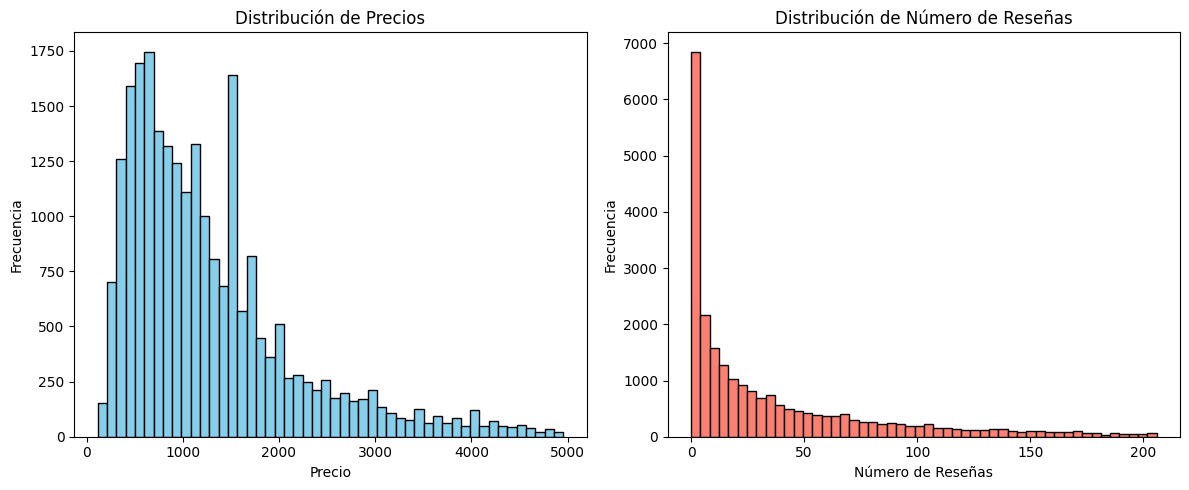

In [13]:
# Crear histogramas
plt.figure(figsize=(12, 5))

# Histograma para Price
plt.subplot(1, 2, 1)
plt.hist(df_cleaned['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

# Histograma para Number of Reviews
plt.subplot(1, 2, 2)
plt.hist(df_cleaned['number_of_reviews'], bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


En estos histogramas podemos obserbar la distribucion de precios y de reseñas:
- En la distribución de precios (izquierda), la mayoría de los listados tienen
precios entre 500 y 2,000 pesos, con un pico notable alrededor de los 1,000 pesos. A medida que el precio aumenta, la cantidad de listados disminuye significativamente, pero aún existen listados premium con precios cercanos a los 5,000 pesos, aunque son poco frecuentes.

- En la distribución del número de reseñas (derecha), observamos que un gran porcentaje de los listados tienen menos de 10 reseñas, siendo 0 reseñas el valor más frecuente. Sin embargo, algunos listados muy populares destacan al contar con más de 200 reseñas, lo que indica su alta demanda y uso frecuente.



**¿Qué barrios tienen más listados en Airbnb?**

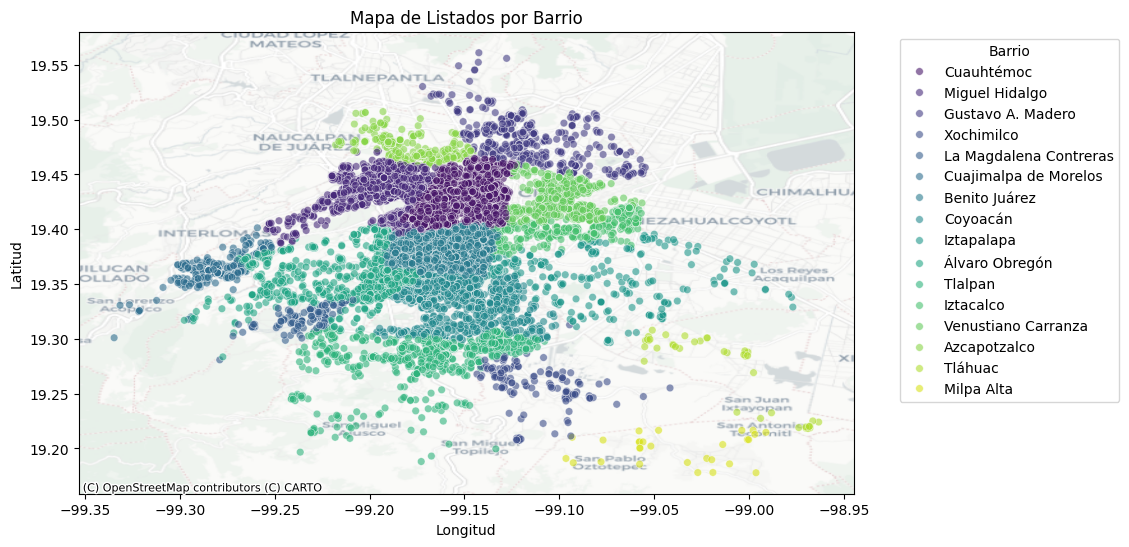

In [14]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar los puntos con latitud y longitud
sns.scatterplot(data=df_cleaned, x='longitude', y='latitude', hue='neighbourhood', palette='viridis', s=30, alpha=0.6, ax=ax)

# Añadir mapa base
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

# Configuración del gráfico
plt.title('Mapa de Listados por Barrio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Barrio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


En el gráfico se observa la distribución geográfica de los listados de Airbnb en la Ciudad de México. La mayoría de los listados se concentran en el centro de la ciudad, especialmente en barrios como Cuauhtémoc, conocido por sus zonas turísticas como la colonia Roma y Condesa, y Miguel Hidalgo, que incluye áreas exclusivas como Polanco.

A medida que nos alejamos del centro, la densidad de listados disminuye notablemente, destacando barrios con menos presencia como Tláhuac y Milpa Alta, ubicados en las periferias de la ciudad, donde la oferta de alojamientos es significativamente menor.

**¿Qué tipos de habitaciones son más populares y donde se encuentran?**

<ipython-input-33-ee2ef55a2e94>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='room_type', order=df_cleaned['room_type'].value_counts().index, palette='mako')


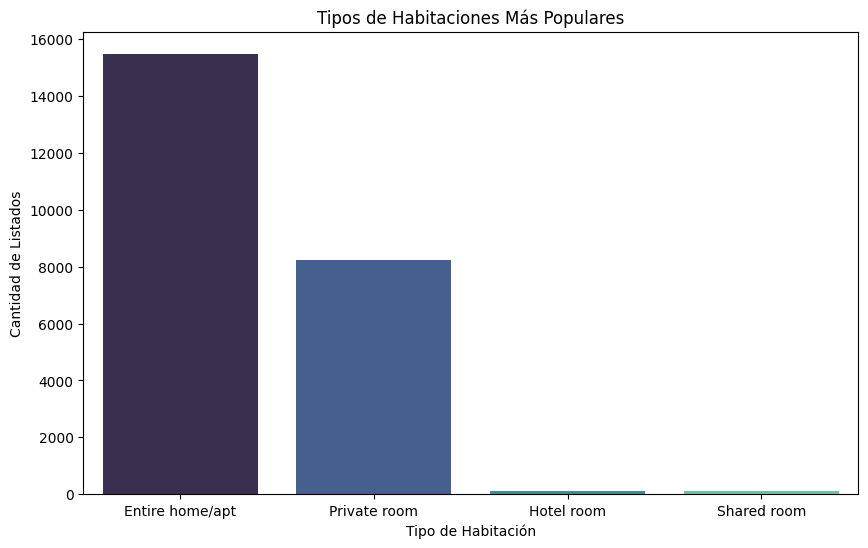

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='room_type', order=df_cleaned['room_type'].value_counts().index, palette='mako')
plt.title('Tipos de Habitaciones Más Populares')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Cantidad de Listados')
plt.show()


<ipython-input-16-83d28eb8ea46>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=entire_home_counts, x='Count', y='Neighbourhood', palette='mako')


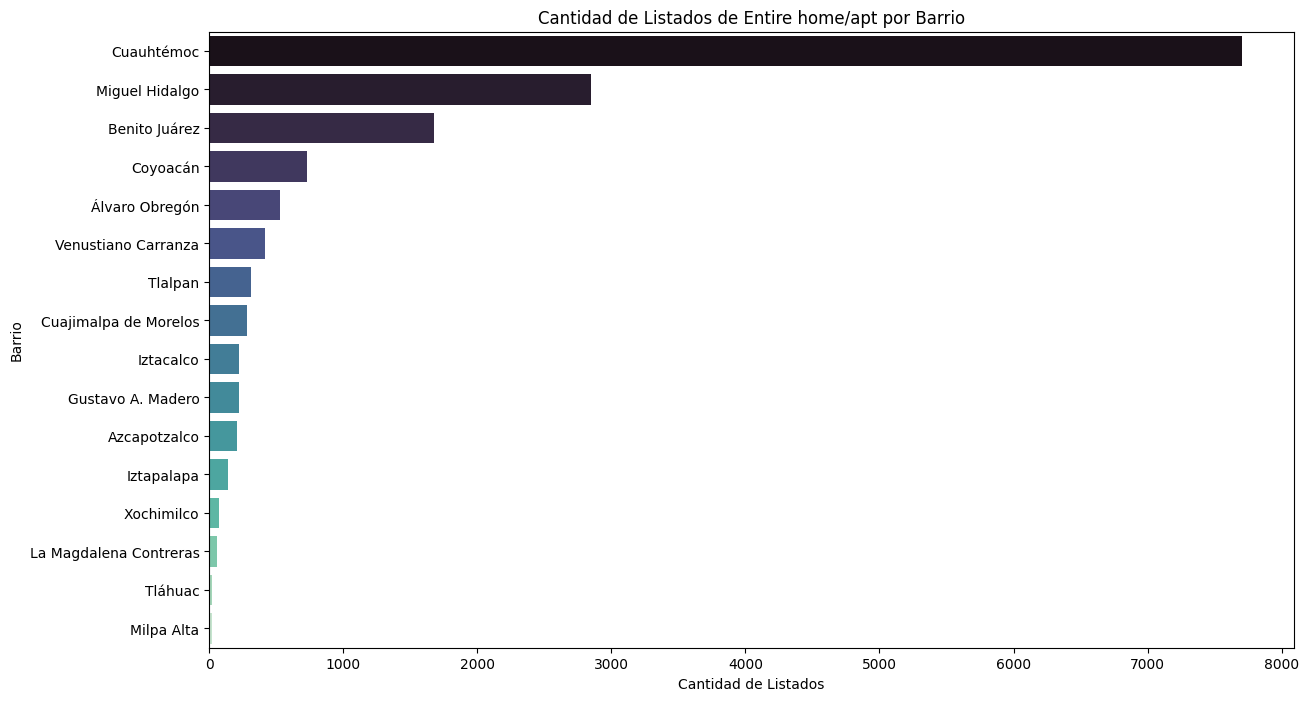

In [16]:
# Filtrar solo las habitaciones de tipo 'Entire home/apt'
entire_home_data = df_cleaned[df_cleaned['room_type'] == 'Entire home/apt']
entire_home_counts = entire_home_data['neighbourhood'].value_counts().reset_index()
entire_home_counts.columns = ['Neighbourhood', 'Count']

# Crear gráfico
plt.figure(figsize=(14, 8))
sns.barplot(data=entire_home_counts, x='Count', y='Neighbourhood', palette='mako')
plt.title('Cantidad de Listados de Entire home/apt por Barrio')
plt.xlabel('Cantidad de Listados')
plt.ylabel('Barrio')
plt.show()


Las gráficas muestran que el tipo de habitación más popular en los listados de Airbnb es el "Entire home/apt" (Casa/apto entero), con una cantidad considerablemente mayor de listados en comparación con otras opciones como las habitaciones privadas, habitaciones de hotel y, en último lugar, las habitaciones compartidas.

El barrio de Cuauhtémoc destaca como el área con la mayor cantidad de listados de "Entire home/apt", lo que no sorprende debido a su ubicación céntrica y su popularidad entre turistas y viajeros. Por otro lado, Milpa Alta se posiciona como el barrio con la menor cantidad de este tipo de alojamientos, reflejando su ubicación periférica y menor actividad turística en comparación con otras zonas de la ciudad.

**¿Qué tan disponibles están los listados durante el año en cada barrio?**

<ipython-input-17-9520a2d1a1a3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_availability.values, y=avg_availability.index, palette='magma')


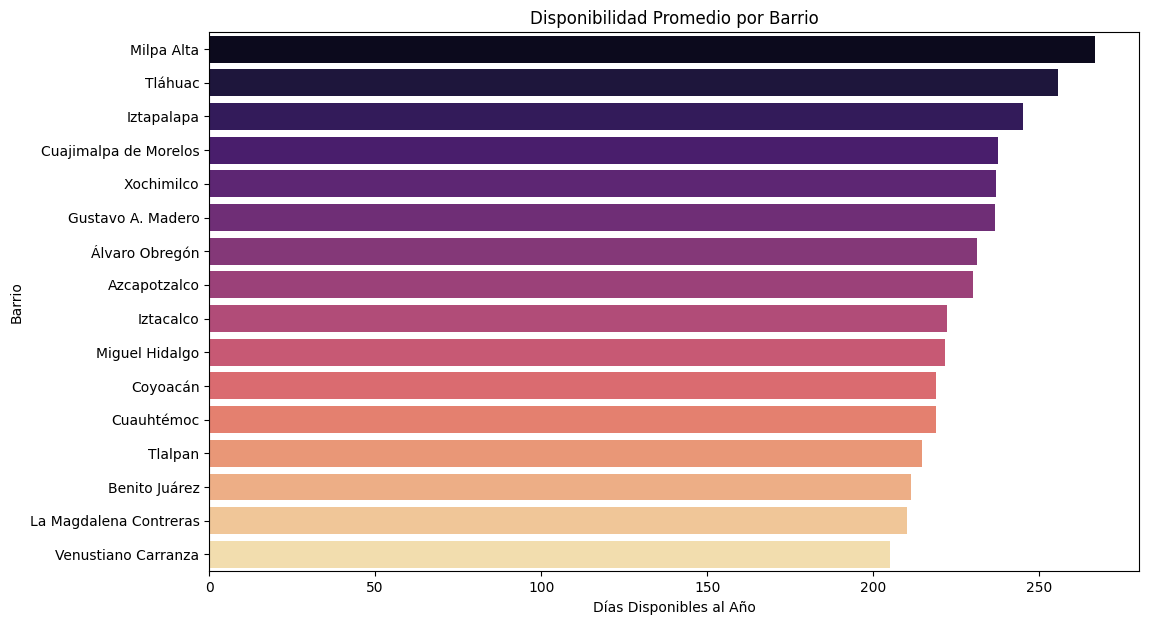

In [17]:
plt.figure(figsize=(12, 7))
avg_availability = df_cleaned.groupby('neighbourhood')['availability_365'].mean().sort_values(ascending=False)
sns.barplot(x=avg_availability.values, y=avg_availability.index, palette='magma')
plt.title('Disponibilidad Promedio por Barrio')
plt.xlabel('Días Disponibles al Año')
plt.ylabel('Barrio')
plt.show()


La gráfica revela que los barrios periféricos de la Ciudad de México presentan una mayor disponibilidad de listados durante el año, encabezados por Milpa Alta, cuya disponibilidad destaca notablemente frente a otras zonas. Este fenómeno podría atribuirse a una menor demanda turística, permitiendo que los listados permanezcan disponibles por más tiempo. Tláhuac e Iztapalapa siguen la misma tendencia, lo que sugiere que, aunque ofrecen precios accesibles, no son las zonas más buscadas por los visitantes.

En contraste, barrios céntricos y populares como Miguel Hidalgo, Cuauhtémoc y Benito Juárez muestran una disponibilidad significativamente menor, probablemente debido a la alta rotación y demanda constante de turistas, lo que hace que las propiedades se ocupen rápidamente y con frecuencia.

Podemos suponer que los barrios periféricos pueden representar una oportunidad para estancias más flexibles, mientras que las zonas centrales, aunque con menor disponibilidad, mantienen una ocupación constante gracias a su atractivo turístico.



**¿Qué barrios tienen los precios más altos y cuáles los más bajos?**

<ipython-input-18-63e6f77d650f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='neighbourhood', y='price', palette='magma')


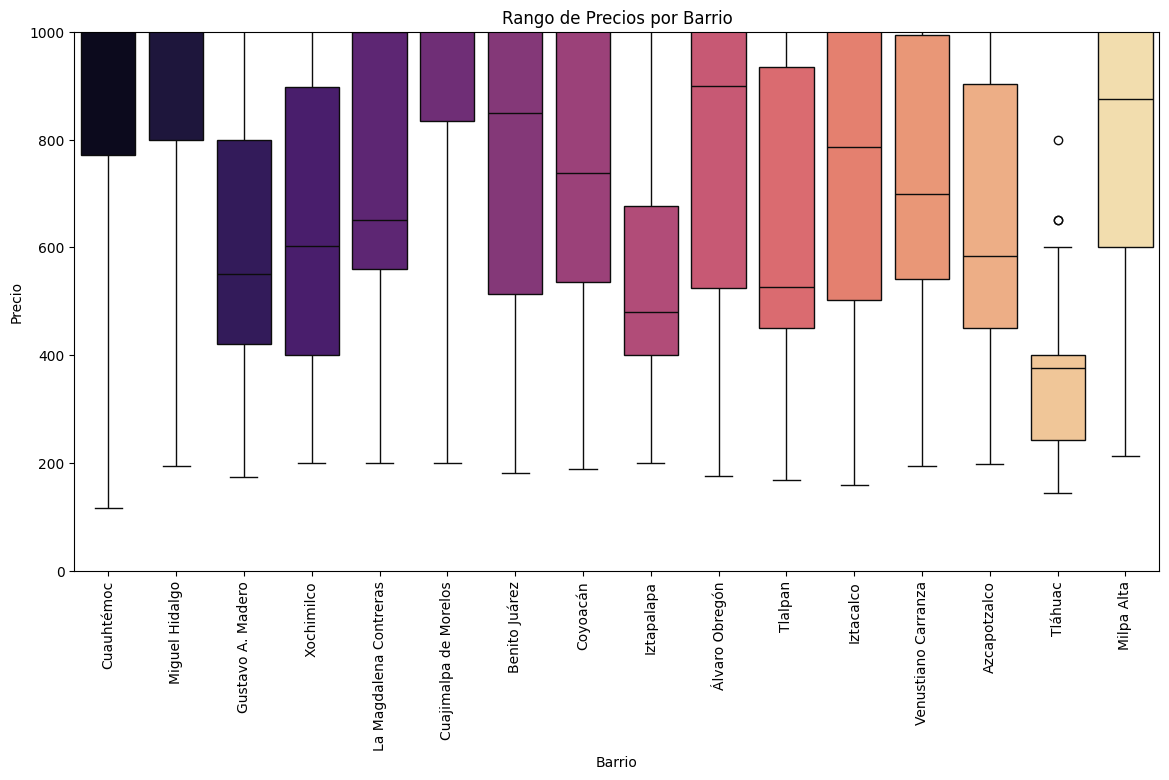

In [18]:
# Rango de precios en cada zona
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_cleaned, x='neighbourhood', y='price', palette='magma')
plt.title('Rango de Precios por Barrio')
plt.xlabel('Barrio')
plt.ylabel('Precio')
plt.xticks(rotation=90)
plt.ylim(0, 1000)
plt.show()

En este Boxplot podemos observar que distribución del rango de precios en cada barrio de la Ciudad de México. Se observa que Cuauhtémoc y Miguel Hidalgo tienen una amplia dispersión de precios, desde opciones accesibles hasta alojamientos de lujo, lo que refuerza su popularidad y variedad de oferta.

Por otro lado, Milpa Alta, aunque presenta precios elevados en su mayoría, también muestra una menor dispersión, indicando que los precios son más consistentes y menos variados.

Los barrios con precios más bajos, como Tláhuac e Iztapalapa, no solo mantienen un rango inferior, sino que también tienen una menor dispersión, sugiriendo que la oferta es más homogénea y accesible, aunque con menos demanda turística.

**¿Qué barrios y tipo de habitaciones reciben más reseñas al mes?**

<ipython-input-19-63e06382274b>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reviews_neighbourhood.values, y=top_reviews_neighbourhood.index, palette='viridis')


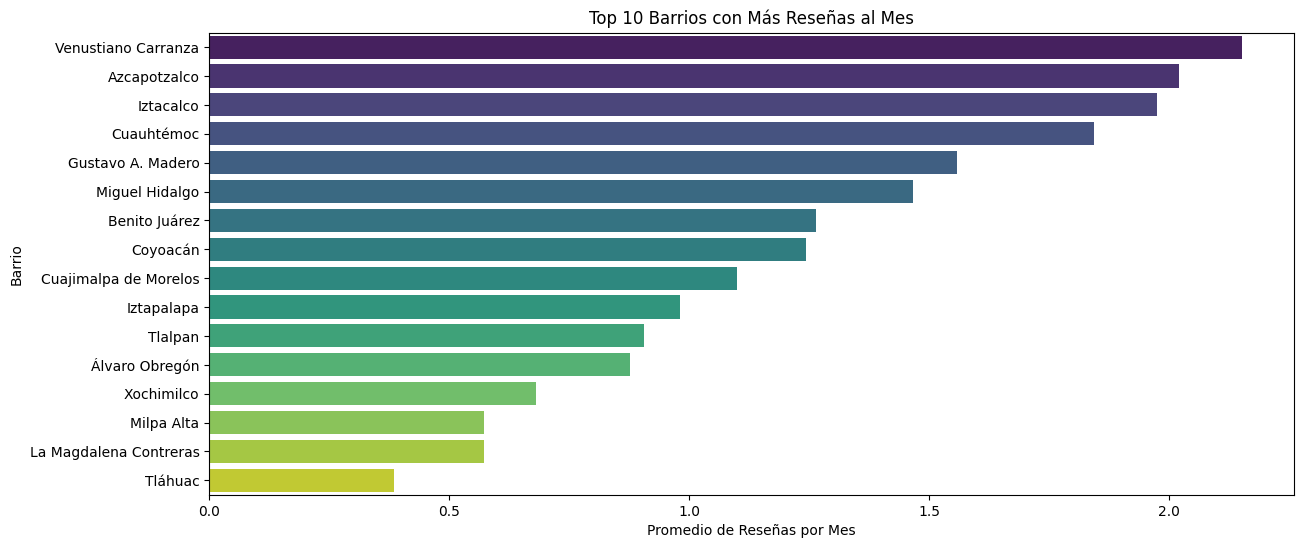

<ipython-input-19-63e06382274b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cleaned, x='room_type', y='reviews_per_month', palette='mako')


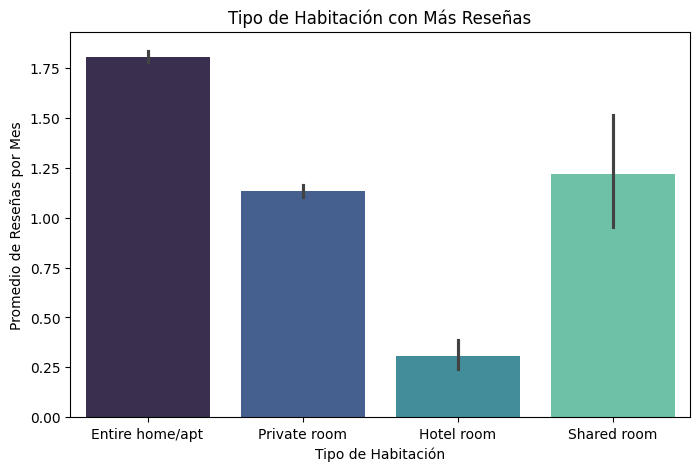

In [19]:
# Barrios con más reseñas al mes
plt.figure(figsize=(14, 6))
top_reviews_neighbourhood = df_cleaned.groupby('neighbourhood')['reviews_per_month'].mean().sort_values(ascending=False)
sns.barplot(x=top_reviews_neighbourhood.values, y=top_reviews_neighbourhood.index, palette='viridis')
plt.title('Top 10 Barrios con Más Reseñas al Mes')
plt.xlabel('Promedio de Reseñas por Mes')
plt.ylabel('Barrio')
plt.show()

# Tipo de habitación con más reseñas
plt.figure(figsize=(8, 5))
sns.barplot(data=df_cleaned, x='room_type', y='reviews_per_month', palette='mako')
plt.title('Tipo de Habitación con Más Reseñas')
plt.xlabel('Tipo de Habitación')
plt.ylabel('Promedio de Reseñas por Mes')
plt.show()

Los gráficos muestran que Venustiano Carranza lidera en el promedio de reseñas mensuales, destacándose notablemente a pesar de no figurar entre los barrios más caros ni con mayor disponibilidad, lo que sugiere que su popularidad podría estar relacionada con factores como accesibilidad o relación calidad-precio. Azcapotzalco e Iztacalco, que también mantienen una presencia intermedia en las demás métricas, ocupan los siguientes puestos, mientras que Cuauhtémoc, conocido por su alta demanda turística, aparece en cuarto lugar, lo cual sorprende considerando su gran cantidad de listados y precios altos.

Por otro lado, Tlahuac, con precios más bajos y mayor disponibilidad, muestra un menor número de reseñas mensuales, lo que podría indicar una menor atracción turística o preferencia por otras zonas.

En cuanto al tipo de habitación, Entire home/apt no solo es la opción más popular, sino también la que recibe más reseñas, lo que refuerza su preferencia entre los huéspedes. Un dato interesante es que las habitaciones compartidas (Shared room) reciben más reseñas que las habitaciones privadas (Private room) y las habitaciones de hotel (Hotel room), lo que podría reflejar una mayor interacción social en este tipo de alojamientos o un menor costo que motiva a los viajeros a compartir sus experiencias con mayor frecuencia.

**¿Qué factores afectan más el precio de un listado?**

In [34]:
# Crear el objeto LabelEncoder
le = LabelEncoder()

# Guardar el mapeo de `room_type` antes de la transformación
room_type_mapping = dict(zip(df_cleaned['room_type'].unique(), le.fit(df_cleaned['room_type']).transform(df_cleaned['room_type'].unique())))
df_cleaned['room_type'] = le.transform(df_cleaned['room_type'])

# Guardar el mapeo de `neighbourhood` antes de la transformación
neighbourhood_mapping = dict(zip(df_cleaned['neighbourhood'].unique(), le.fit(df_cleaned['neighbourhood']).transform(df_cleaned['neighbourhood'].unique())))
df_cleaned['neighbourhood'] = le.transform(df_cleaned['neighbourhood'])

# Verificar los mapeos creados
print("Room Type Mapping:", room_type_mapping)
print("Neighbourhood Mapping:", neighbourhood_mapping)

Room Type Mapping: {'Entire home/apt': 0, 'Private room': 2, 'Hotel room': 1, 'Shared room': 3}
Neighbourhood Mapping: {'Cuauhtémoc': 4, 'Miguel Hidalgo': 9, 'Gustavo A. Madero': 5, 'Xochimilco': 14, 'La Magdalena Contreras': 8, 'Cuajimalpa de Morelos': 3, 'Benito Juárez': 1, 'Coyoacán': 2, 'Iztapalapa': 7, 'Álvaro Obregón': 15, 'Tlalpan': 11, 'Iztacalco': 6, 'Venustiano Carranza': 13, 'Azcapotzalco': 0, 'Tláhuac': 12, 'Milpa Alta': 10}


<ipython-input-34-8d1288c9f1d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['room_type'] = le.transform(df_cleaned['room_type'])
<ipython-input-34-8d1288c9f1d3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['neighbourhood'] = le.transform(df_cleaned['neighbourhood'])


In [21]:
# Calcular el VIF para revisar multicolinealidad entre variables
X = df_cleaned[['minimum_nights', 'availability_365', 'number_of_reviews',
                        'reviews_per_month', 'calculated_host_listings_count',
                        'number_of_reviews_ltm', 'room_type', 'neighbourhood', 'price']]

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                         Variable       VIF
0                  minimum_nights  1.044052
1                availability_365  3.182467
2               number_of_reviews  2.906079
3               reviews_per_month  4.941653
4  calculated_host_listings_count  1.254348
5           number_of_reviews_ltm  5.872603
6                       room_type  1.545514
7                   neighbourhood  2.526993
8                           price  2.742990


Las variables reviews_per_month y number_of_reviews_ltm presentan un VIF cercano a 5 y 5.87, respectivamente, lo que sugiere una posible multicolinealidad con otras variables. Esto puede afectar la estabilidad de nuestro análisis al inflar las varianzas de los coeficientes estimados en los modelos. Aunque no exceden el umbral crítico de 10, su valor elevado indica que sería conveniente analizar con mayor detalle su relación con otras variables para evitar posibles distorsiones en los resultados.

In [22]:
# Crear y ajustar modelo de regresion lineal
y, X = dmatrices('price ~ minimum_nights + availability_365 + number_of_reviews + C(neighbourhood) + C(room_type) + calculated_host_listings_count', data=df_cleaned, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     455.8
Date:                Mon, 17 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:39:15   Log-Likelihood:            -1.9229e+05
No. Observations:               23940   AIC:                         3.846e+05
Df Residuals:                   23917   BIC:                         3.848e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Este modelo de regresión lineal OLS analiza cómo diferentes factores afectan el precio de los listados de Airbnb. El intercepto, de aproximadamente 967.81, representa el precio estimado cuando todas las variables son cero. Se observa que los barrios influyen significativamente en el precio: algunos, como el neighbourhood[T.9] (+729.56), están asociados a precios más altos, mientras que otros, como neighbourhood[T.12] (-309.16), presentan precios más bajos. El tipo de habitación también es determinante; por ejemplo, room_type[T.1] (+474.03) eleva el precio, mientras que room_type[T.2] (-776.39) y room_type[T.3] (-1213.66) lo reducen. Entre las variables numéricas, el número mínimo de noches (-1.30) y la cantidad de reseñas (-1.14) muestran una ligera relación negativa con el precio, mientras que la disponibilidad (+0.32) y el número de listados por anfitrión (+2.08) tienen un efecto positivo.

El coeficiente de determinación (R² = 0.295) indica que el modelo explica aproximadamente el 29.5% de la variabilidad en los precios, lo que es razonable considerando la naturaleza compleja del mercado. Además, la mayoría de las variables son estadísticamente significativas (p < 0.05), lo que valida su relevancia en el análisis. En resumen, el precio está principalmente influenciado por la ubicación y el tipo de alojamiento, mientras que factores como la disponibilidad o las reseñas tienen un impacto menor.

**¿Qué factores podrían hacer que un barrio tenga menos disponibilidad?**

In [23]:
y, X = dmatrices('availability_365 ~ minimum_nights + number_of_reviews + price + C(neighbourhood) + C(room_type) + calculated_host_listings_count', data=df_cleaned, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       availability_365   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     29.65
Date:                Mon, 17 Feb 2025   Prob (F-statistic):          5.24e-122
Time:                        14:39:19   Log-Likelihood:            -1.5068e+05
No. Observations:               23940   AIC:                         3.014e+05
Df Residuals:                   23917   BIC:                         3.016e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

El modelo de regresión lineal explica solo el 2.7% de la variabilidad en la disponibilidad de listados (availability_365), lo que indica que hay muchos otros factores no considerados. Aun así, el modelo es significativo en su conjunto (p < 0.05).

Tipos de habitación como Private room (+19.45) y Shared room (+75.52) tienen más días disponibles en comparación con Entire home/apt.
Mayor precio (+0.0098) y más listados por anfitrión (+0.4463) están asociados con mayor disponibilidad, indicando que propiedades más caras o gestionadas por múltiples listados se reservan con menor frecuencia.
El valor de minimum_nights (-0.1864) reduce ligeramente la disponibilidad a medida que aumenta el mínimo de noches requeridas.


**¿Cuáles son las mejores zonas para invertir en un Airbnb?(Tomando en cuenta precio, disponibilidad y popularidad).**

In [35]:
# Invertir el mapeo de `room_type`
inverse_room_type_mapping = {v: k for k, v in room_type_mapping.items()}
df_cleaned['room_type'] = df_cleaned['room_type'].map(inverse_room_type_mapping)

# Invertir el mapeo de `neighbourhood`
inverse_neighbourhood_mapping = {v: k for k, v in neighbourhood_mapping.items()}
df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].map(inverse_neighbourhood_mapping)

# Verificar que se haya revertido correctamente
print(df_cleaned[['room_type', 'neighbourhood']].head())



         room_type   neighbourhood
1  Entire home/apt      Cuauhtémoc
4     Private room  Miguel Hidalgo
5     Private room      Cuauhtémoc
6       Hotel room      Cuauhtémoc
7  Entire home/apt      Cuauhtémoc


<ipython-input-35-2b32ce2fd5b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['room_type'] = df_cleaned['room_type'].map(inverse_room_type_mapping)
<ipython-input-35-2b32ce2fd5b7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].map(inverse_neighbourhood_mapping)


<ipython-input-36-f2040960dbb9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_investment_zones['score'], y=top_investment_zones.index, palette='magma')


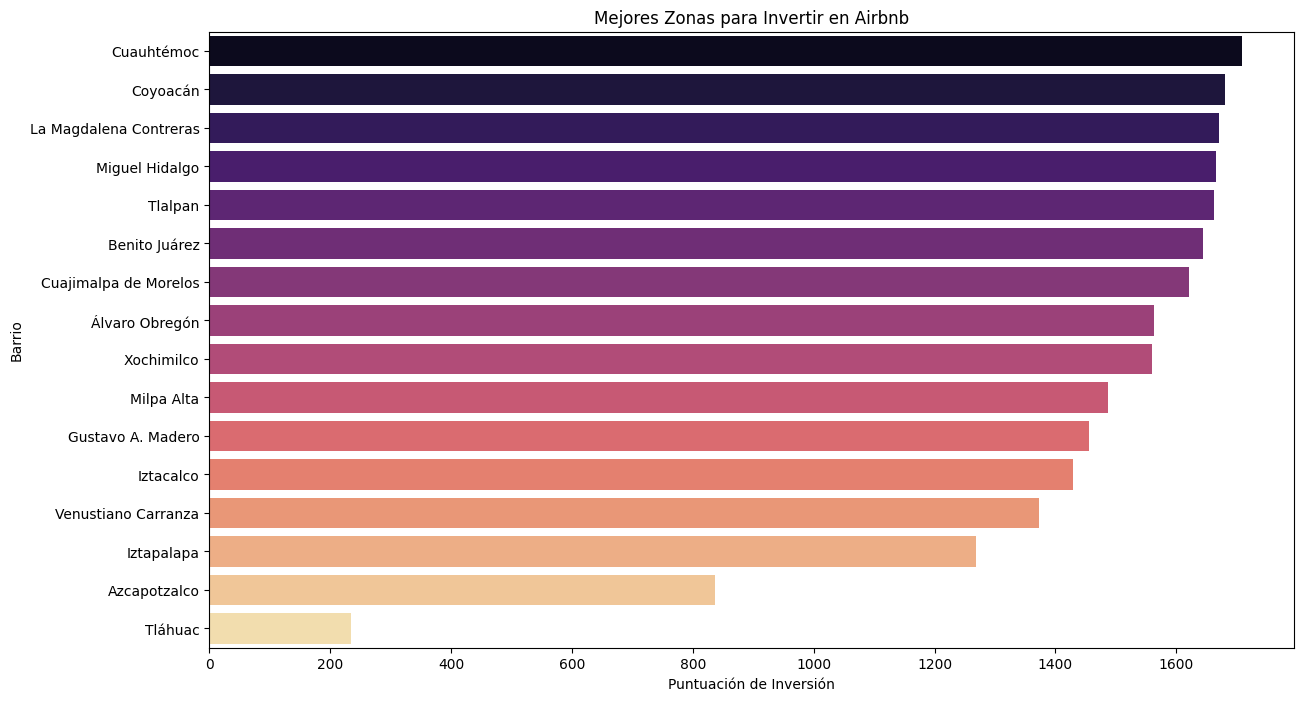

In [36]:
plt.figure(figsize=(14, 8))

# Calcular el rango de precios por barrio
price_range = df_cleaned.groupby('neighbourhood')['price'].agg(lambda x: x.max() - x.min())
investment_zones = df_cleaned.groupby('neighbourhood')[['availability_365', 'number_of_reviews']].mean()

# Agregar el rango de precios al DataFrame
investment_zones['price_range'] = price_range
investment_zones['score'] = (investment_zones['number_of_reviews'] * 0.4) + \
                            (investment_zones['price_range'] * 0.35) - \
                            (1 / (investment_zones['availability_365'] + 1) * 0.25)

# Ordenar por la puntuación calculada
top_investment_zones = investment_zones.sort_values(by='score', ascending=False)

# Graficar
sns.barplot(x=top_investment_zones['score'], y=top_investment_zones.index, palette='magma')
plt.title('Mejores Zonas para Invertir en Airbnb')
plt.xlabel('Puntuación de Inversión')
plt.ylabel('Barrio')
plt.show()



Las mejores cinco zonas para invertir en Airbnb en la Ciudad de México, según la puntuación calculada, son Cuauhtémoc, Coyoacán, La Magdalena Contreras, Miguel Hidalgo y Tlalpan. Esta clasificación se obtiene mediante un análisis que pondera el número de reseñas, el rango de precios y la disponibilidad, dando más peso a aquellas zonas con alto movimiento de reseñas y una mayor variedad de precios. Por otro lado, las zonas menos recomendadas para invertir son Iztacalco, Venustiano Carranza, Iztapalapa, Azcapotzalco y Tláhuac, debido a su menor atractivo según los mismos criterios. Este modelo prioriza barrios con alta actividad de usuarios (reseñas), una amplia variabilidad en precios (posibilidades de rentabilidad diversa) y menor disponibilidad, ya que una alta ocupación suele reflejar mayor demanda y competitividad en la zona.

<ipython-input-37-81493dad70dd>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_investment_rooms['score'], y=top_investment_rooms.index, palette='magma')


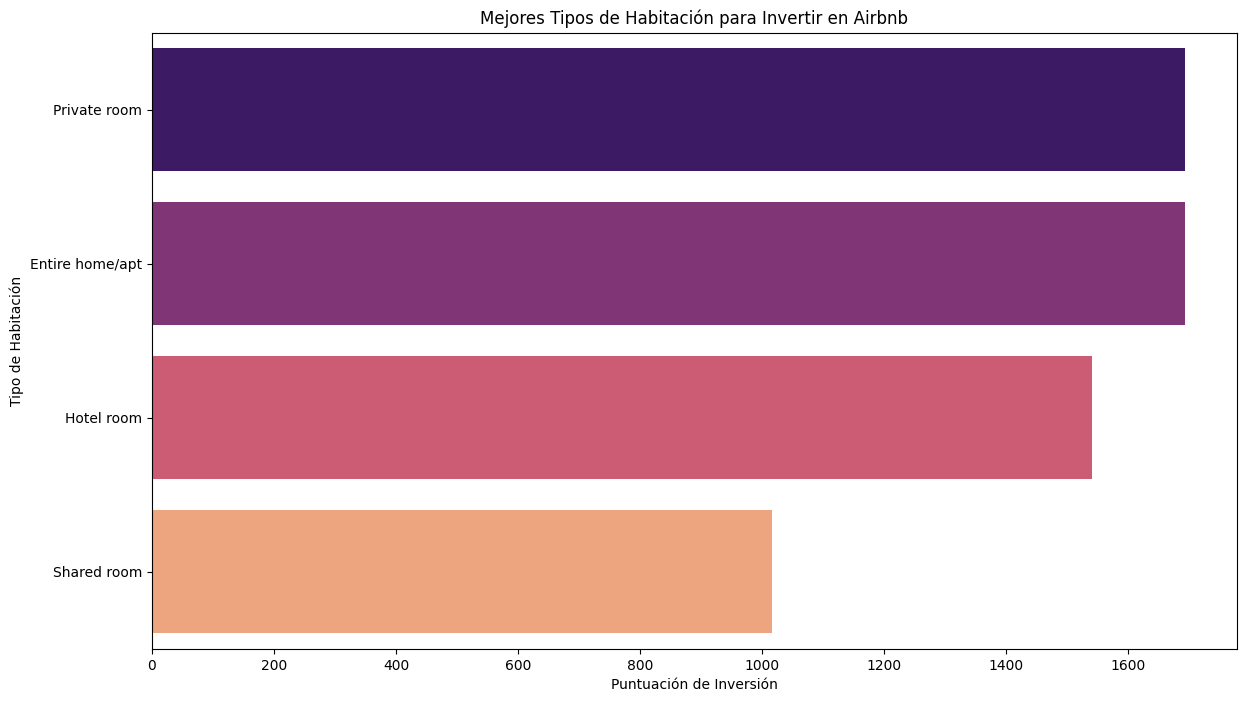

In [37]:
plt.figure(figsize=(14, 8))

# Calcular el rango de precios por tipo de habitación
price_range_room = df_cleaned.groupby('room_type')['price'].agg(lambda x: x.max() - x.min())
investment_rooms = df_cleaned.groupby('room_type')[['availability_365', 'number_of_reviews']].mean()

# Agregar el rango de precios al DataFrame
investment_rooms['price_range'] = price_range_room

# Calcular la puntuación de inversión con las ponderaciones ajustadas
investment_rooms['score'] = (investment_rooms['number_of_reviews'] * 0.4) + \
                            (investment_rooms['price_range'] * 0.35) - \
                            (1 / (investment_rooms['availability_365'] + 1) * 0.25)

# Ordenar por la puntuación calculada
top_investment_rooms = investment_rooms.sort_values(by='score', ascending=False)

# Graficar
sns.barplot(x=top_investment_rooms['score'], y=top_investment_rooms.index, palette='magma')
plt.title('Mejores Tipos de Habitación para Invertir en Airbnb')
plt.xlabel('Puntuación de Inversión')
plt.ylabel('Tipo de Habitación')
plt.show()


In [27]:
# Guardar el DataFrame limpio en CSV
df_cleaned.to_csv('airbnb_cleaned.csv', index=False)

from google.colab import files
files.download('airbnb_cleaned.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>